In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import SimpleITK as sitk
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random
import time

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from skimage import io

In [2]:
image_size = 224

labels = ['1_Normal', '2_Pneumonia','3_Covid_19']

In [3]:
def preprocess_input(x):
    x -= 0.5
    x *= 2.
    x = np.float16(x)
    return x

In [4]:
def create_data(paths):
    
    images = []
    
    for label in labels:
        dir = os.path.join(paths,label)
        class_num = labels.index(label)
        
        for image in os.listdir(dir):
            image_read = cv.imread(os.path.join(dir,image))
            image_resized = cv.resize(image_read,(image_size,image_size),cv.IMREAD_GRAYSCALE)
            image_resized = image_resized /255.0
            image_resized = preprocess_input(image_resized)
            
            images.append([image_resized,class_num])
            
    return np.array(images)

#create the training and validation set

train = create_data('D:/Kaggle datasets/Covid_19_CT_25/train')
test = create_data('D:/Kaggle datasets/Covid_19_CT_25/test')
val = create_data('D:/Kaggle datasets/Covid_19_CT_25/val')

print(f'Shape of the training images = {train.shape}')
print(f'Shape of the test images = {test.shape}')
print(f'Shape of the validation images = {val.shape}')

C:\Users\asarkar\.conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Shape of the training images = (26338, 2)
Shape of the test images = (56635, 2)
Shape of the validation images = (21036, 2)


In [5]:
#load train images and labels in X_train and y_train

X_train = []
y_train = []

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)
    
X_train = np.array(X_train)
y_train = np.array(y_train)
y_train = np.expand_dims(y_train, axis=1)

print(X_train.shape)
print(y_train.shape)

(26338, 224, 224, 3)
(26338, 1)


In [6]:
#load test images and labels in X_test and y_test

X_test = []
y_test = []

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)
    
X_test = np.array(X_test)
y_test = np.array(y_test)
y_test = np.expand_dims(y_test, axis=1)

print(X_test.shape)
print(y_test.shape)

(56635, 224, 224, 3)
(56635, 1)


In [7]:
#Load validation images and labels in X_val and y_val

X_val = []
y_val = []

for feature, label in val:
    X_val.append(feature)
    y_val.append(label)
    
X_val = np.array(X_val)
y_val = np.array(y_val)
y_val = np.expand_dims(y_val, axis=1)

print(X_val.shape)
print(y_val.shape)

(21036, 224, 224, 3)
(21036, 1)


Number of Normal images = 12464
Number of Pneumonia images = 9238
Number of Covid-19 images = 4636


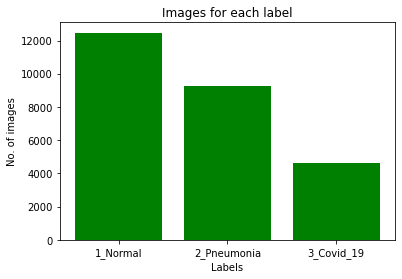

In [8]:
#check the number of images in each class in train set

a = 0
b = 0
c = 0

for label in y_train:
    if label == 0:
        a += 1
    if label == 1:
        b += 1
    if label == 2:
        c += 1
        
print (f'Number of Normal images = {a}')
print (f'Number of Pneumonia images = {b}')
print (f'Number of Covid-19 images = {c}')

# plotting the data

xe = [i for i, _ in enumerate(labels)]

numbers = [a,b,c]
plt.bar(xe,numbers,color = 'green')
plt.xlabel("Labels")
plt.ylabel("No. of images")
plt.title("Images for each label")

plt.xticks(xe, labels)

plt.show()

In [9]:
a= y_train.flatten()
a
a.shape

(26338,)

In [10]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(a),
                                                 a)
print(class_weights)

[0.70437527 0.95035    1.89373023]


C:\Users\asarkar\.conda\envs\gpu\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1 2], y=[0 0 0 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [11]:
# create the base pre-trained model
input_shape = [224,224]

base_model = ResNet50V2 (input_shape = input_shape+[3], weights = 'imagenet', include_top = False)

x = base_model.output

x = GlobalAveragePooling2D()(x)

x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
x = Dropout(0.5)(x)

# and a logistic layer
out = Dense(3, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=out)

In [12]:
def scheduler(epoch):
    if epoch < 30:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

stopping = EarlyStopping(monitor='val_loss', patience=5)

In [13]:
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()  

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [14]:
callbacks = ModelCheckpoint('CT_Resnet_25.h5', monitor='val_loss', verbose=1, save_best_only=True, mode = 'auto')

batch_size = 2

r = model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=batch_size, epochs =100,
                        callbacks = [callbacks,lr_schedule,stopping],class_weight=class_weights)

Train on 26338 samples, validate on 21036 samples
Epoch 1/100
26336/26338 [============================>.] - ETA: 0s - loss: 0.4200 - accuracy: 0.9474
Epoch 00001: val_loss improved from inf to 1.08796, saving model to CT_Resnet_25.h5
26338/26338 [==============================] - 613s 23ms/sample - loss: 0.4200 - accuracy: 0.9474 - val_loss: 1.0880 - val_accuracy: 0.7508
Epoch 2/100
26336/26338 [============================>.] - ETA: 0s - loss: 0.0793 - accuracy: 0.9872
Epoch 00002: val_loss improved from 1.08796 to 0.31162, saving model to CT_Resnet_25.h5
26338/26338 [==============================] - 616s 23ms/sample - loss: 0.0793 - accuracy: 0.9872 - val_loss: 0.3116 - val_accuracy: 0.9125
Epoch 3/100
26334/26338 [============================>.] - ETA: 0s - loss: 0.0464 - accuracy: 0.9910
Epoch 00003: val_loss did not improve from 0.31162
26338/26338 [==============================] - 618s 23ms/sample - loss: 0.0464 - accuracy: 0.9910 - val_loss: 1.7457 - val_accuracy: 0.7830
Epoc

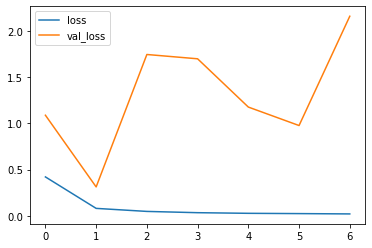

In [15]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

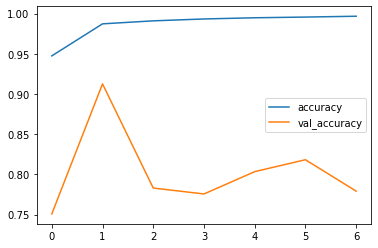

In [16]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [17]:
def perf_measure(y_holdout, P):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(P)): 
        if y_holdout[i]==P[i]==1:
           TP += 1
        if y_holdout[i]==1 and y_holdout[i]!=P[i]:
           FN += 1
        if y_holdout[i]==P[i]==0:
           TN += 1
        if y_holdout[i]==0 and y_holdout[i]!=P[i]:
           FP += 1

    return(TP, FP, TN, FN)

In [18]:
final_model = tf.keras.models.load_model('CT_Resnet_25.h5')

### Val Metrics

In [19]:
P_val= final_model.predict(X_val, batch_size = 4).argmax(axis=1)
print(P_val)

[0 0 0 ... 1 1 1]


([<matplotlib.axis.YTick at 0x2ae97251348>,
 [Text(0, 0, '1_Normal'), Text(0, 1, '2_Pneumonia'), Text(0, 2, '3_Covid_19')])

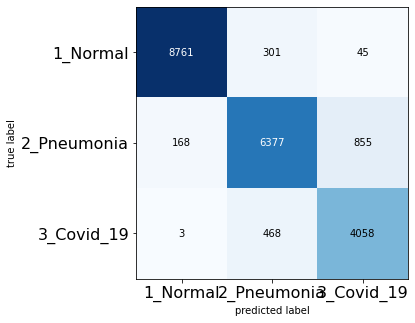

In [20]:
matrix1 = confusion_matrix (y_val, P_val)
plot_confusion_matrix(matrix1, figsize=(5,5))
plt.xticks(range(3), ['1_Normal','2_Pneumonia','3_Covid_19'], fontsize=16)
plt.yticks(range(3), ['1_Normal','2_Pneumonia','3_Covid_19'], fontsize=16)

In [21]:
tp, fp, tn ,fn = perf_measure(y_val,P_val)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F-Score is {:.2f}".format(f_score))

Recall of the model is 0.86
Precision of the model is 0.95
F-Score is 0.90


### Test Metrics

In [22]:
P_test= final_model.predict(X_test, batch_size=4).argmax(axis=1)
print(P_test)

[0 0 0 ... 2 2 2]


([<matplotlib.axis.YTick at 0x2ae9720c8c8>,
 [Text(0, 0, '1_Normal'), Text(0, 1, '2_Pneumonia'), Text(0, 2, '3_Covid_19')])

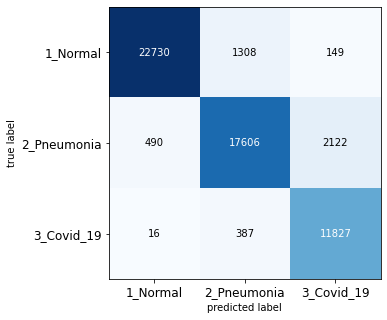

In [23]:
matrix1 = confusion_matrix (y_test, P_test)
plot_confusion_matrix(matrix1, figsize=(5,5))
plt.xticks(range(3), ['1_Normal','2_Pneumonia','3_Covid_19'], fontsize=12)
plt.yticks(range(3), ['1_Normal','2_Pneumonia','3_Covid_19'], fontsize=12)

In [24]:
tp, fp, tn ,fn = perf_measure(y_test,P_test)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of the model is {:.2f}".format(recall*100))
print("Precision of the model is {:.2f}".format(precision*100))
print("F-Score is {:.2f}".format(f_score*100))

Recall of the model is 87.08
Precision of the model is 92.36
F-Score is 89.64


In [25]:
tp, fp, tn ,fn = perf_measure(y_test==0,P_test==0)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of Normal is {:.2f}".format(recall*100))
print("Precision of Normal is {:.2f}".format(precision*100))
print("F-Score of Normal is {:.2f}".format(f_score*100))

Recall of Normal is 93.98
Precision of Normal is 97.82
F-Score of Normal is 95.86


In [26]:
tp, fp, tn ,fn = perf_measure(y_test==1,P_test==1)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of Pneumonia is {:.2f}".format(recall*100))
print("Precision of Pneumonia is {:.2f}".format(precision*100))
print("F-Score of Pneumonia is {:.2f}".format(f_score*100))

Recall of Pneumonia is 87.08
Precision of Pneumonia is 91.22
F-Score of Pneumonia is 89.10


In [27]:
tp, fp, tn ,fn = perf_measure(y_test==2,P_test==2)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of Covid_19 is {:.2f}".format(recall*100))
print("Precision of Covid_19 is {:.2f}".format(precision*100))
print("F-Score of Covid_19 is {:.2f}".format(f_score*100))

Recall of Covid_19 is 96.70
Precision of Covid_19 is 83.89
F-Score of Covid_19 is 89.84
